In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [23]:
class CompareFeatures():
    def __init__(self):
        #特徴点抽出
        # AgastFeature検出器の生成
#         self.detector = cv2.AgastFeatureDetector_create()
        # FAST検出器の生成
#         self.detector = cv2.FastFeatureDetector_create()
        # MSER検出器の生成
#         self.detector = cv2.MSER_create()

        # 特徴量抽出
        # A-KAZE検出器の生成
#         self.detector = cv2.AKAZE_create()
        # BRISK検出器の生成
#         self.detector = cv2.BRISK_create()
        # KAZE検出器の生成
        self.detector = cv2.KAZE_create()
        # ORB (Oriented FAST and Rotated BRIEF)検出器の生成
#         self.detector = cv2.ORB_create()
        # SimpleBlob検出器の生成
#         self.detector = cv2.SimpleBlobDetector_create()

        # Brute-Force Matcher生成
        self.bf=cv2.BFMatcher(cv2.NORM_L1,crossCheck=False)

    def load_imgs(self,base_img,match_img, scale=(1,1)):
        try:
            # 画像
            if base_img:
                self.base=cv2.imread(base_img)
            ma=cv2.imread(match_img)
            self.match=cv2.resize(ma, (int(ma.shape[:2][1]/scale[1]),int(ma.shape[:2][0]/scale[1])))
        except Exception as e:
            print("{}".format(e))

    def run_filter(self, img, prev=False):
#         after=self.to_grayscale(img)
#         after=self.binary_threshold(img)
#         after=self.blur(img)
#         after=self.mask_blue(img)
        after=self.emphasize_edge(img)
#         after=self.blur(after)
#         after=self.morph(after)
        if prev:
            self.view_matplot(after)
        return after
#         return img

    def f_match(self, k_num=2, drop_ratio=0.9):
        # 特徴を際立たせるため filter処理による前処理を実施
        match = self.run_filter(self.match, prev=False)
        base = self.run_filter(self.base, prev=False)

        # 特徴量の検出と特徴量ベクトルの計算
        kp1, des1 = self.detector.detectAndCompute(match, None)
        kp2, des2 = self.detector.detectAndCompute(base, None)
        print("{0} : {1}".format(len(kp1),len(kp2)))
        view_dst = True
        if view_dst:
            img_kp1 = cv2.drawKeypoints(self.match, kp1, None)
            self.view_matplot(img_kp1)
            img_kp2 = cv2.drawKeypoints(self.base, kp2, None)
            self.view_matplot(img_kp2)        
#         kp1 = self.detector.detect(self.match)
#         kp2 = self.detector.detect(self.base)

        # 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
        matches = self.bf.knnMatch(des1, des2, k=k_num)
        print("Matches origin key points count. : {}".format(len(matches)))
        # データを間引きする
        matched = []
        for m, n in matches:
            if m.distance < drop_ratio * n.distance:
#                 print("{0} : {1}".format(m.distance,n.distance))
                matched.append([m])
        return matched, kp1, kp2

    def show_matching(self):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise

        matched,kp1,kp2 = self.f_match()
        # 対応する特徴点同士を描画
        img = cv2.drawMatchesKnn(self.match, kp1, self.base, kp2, matched, None, flags=2)
        # opencv
#         self.view(img)
        # matplot
        self.view_matplot(img)

    def show_rect(self, IS_PARENT=False):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise
        matched,kp1,kp2 = self.f_match()

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        MIN_MATCH_COUNT = 4
        if len(matched)>=MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            print(dst)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            tgt_img=self.base

            if 'parent_postion' in dir(self) and len(self.parent_postion):
                print(self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())
                tgt_img=self.parent_img['base']

            self.parent_postion = []
            self.parent_img = {}
            if IS_PARENT:
                self.parent_postion=dst[:,0][0]
#                 im[y:y+h, x:x+w]
                trim_img = self.base.copy()
                print(dst[:,0][0][1])
                print(dst[:,0][2][1])
                print(dst[:,0][0][0])
                print(dst[:,0][2][1])
                self.base = trim_img[int(dst[:,0][0][1]):int(dst[:,0][2][1]), int(dst[:,0][0][0]):int(dst[:,0][2][1])]
                self.parent_img['base']=self.base.copy()
                self.parent_img['match']=self.match.copy()

            img2 = cv2.polylines(tgt_img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            cv2.circle(img2, center, 5, (255, 0, 0), -1)
        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            matchesMask = None

        draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                           singlePointColor = None,
                           matchesMask = matchesMask, # draw only inliers
                           flags = 2)

#         img = cv2.drawMatches(self.match, kp1, self.base, kp2, matched, None, **draw_params)
#         img = cv2.drawMatches(self.match, kp1, img2, kp2, matched, None, **draw_params)

        # opencv
#         self.view(img)
        # matplot
        self.view_matplot(img2)

    def get_postion(self, IS_PARENT=False):
        if self.base is None or self.match is None:
            print("Image has not been loaded yet. Please load imgs")
            raise
        matched,kp1,kp2 = self.f_match()

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)

        MIN_MATCH_COUNT = 4
        if len(matched)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in matched ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in matched ]).reshape(-1,1,2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()

            h,w,a = self.match.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            center=(dst[:,0][:,0].mean(),dst[:,0][:,1].mean())
            if 'parent_postion' in dir(self) and len(self.parent_postion):
                print(self.parent_postion)
                center=(self.parent_postion[0]+dst[:,0][:,0].mean(),self.parent_postion[1]+dst[:,0][:,1].mean())

            self.parent_postion = []
            if IS_PARENT:
                self.parent_postion=dst[:,0][0]
            return center

        else:
            print("Not enough matches are found - %d/%d" % (len(matched),MIN_MATCH_COUNT))
            matchesMask = None

    def to_grayscale(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return grayed

    def binary_threshold(self,img):
        grayed = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        under_thresh = 105
        upper_thresh = 145
        maxValue = 255
        th, drop_back = cv2.threshold(grayed, under_thresh, maxValue, cv2.THRESH_BINARY)
        th, clarify_born = cv2.threshold(grayed, upper_thresh, maxValue, cv2.THRESH_BINARY_INV)
        merged = np.minimum(drop_back, clarify_born)
        return merged

    def blur(self, img):
        filtered = cv2.GaussianBlur(img, (11, 11), 0)
        return filtered

    def morph(self, img):
        kernel = np.ones((3, 3),np.uint8)
        opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
        return opened

    def mask_blue(self, img):
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        blue_min = np.array([100, 170, 200], np.uint8)
        blue_max = np.array([120, 180, 255], np.uint8)

        blue_region = cv2.inRange(hsv, blue_min, blue_max)
        white = np.full(img.shape, 255, dtype=img.dtype)
        background = cv2.bitwise_and(white, white, mask=blue_region)  # detected blue area becomes white

        inv_mask = cv2.bitwise_not(blue_region)  # make mask for not-blue area
        extracted = cv2.bitwise_and(img, img, mask=inv_mask)

        masked = cv2.add(extracted, background)

        return masked

    def emphasize_edge(self,img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        canny_img = cv2.Canny(gray, 50, 110)
        return canny_img
    
    def view(self, img):
        # 画像表示
        cv2.imshow('img', img)
        # キー押下で終了
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    def view_matplot(self, img):
        plt.figure(figsize=(16,12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.imshow(img)
        plt.show()

In [24]:
# stub用テストシナリオ
def stub_scenario():
    return

In [25]:
def generate_sub_map():
    return {
        0:{
            'base':'base.jpg',
            'match':'match.jpg',
            'scale':1
        },
        1:{
            'base':'test2.jpg',
            'match':'test1_cut1.jpg',
            'scale':0.5,
            'is_parent':True
        },
        2:{
#             'base':'test1_cut1.jpg',
            'base':None,
            'scale':1,
            'match':'test1_check_box.jpg'
        },
#         3:{
#             'base':'test2.jpg',
#             'match':'test1_cut1.jpg'
#         }
    }

31 : 1003


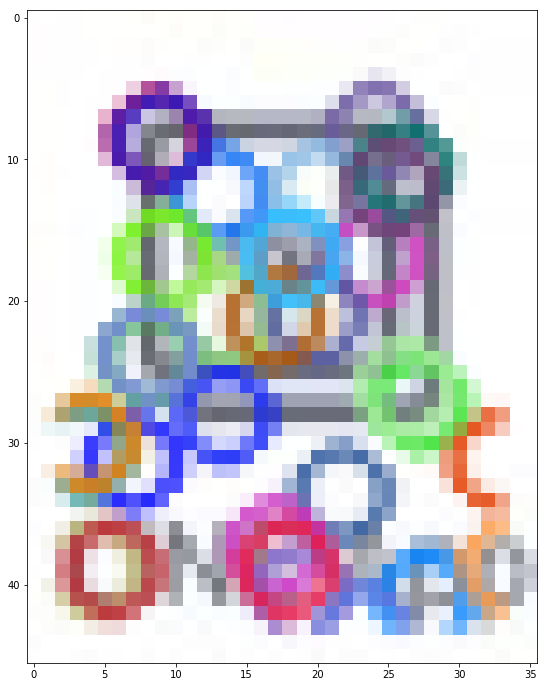

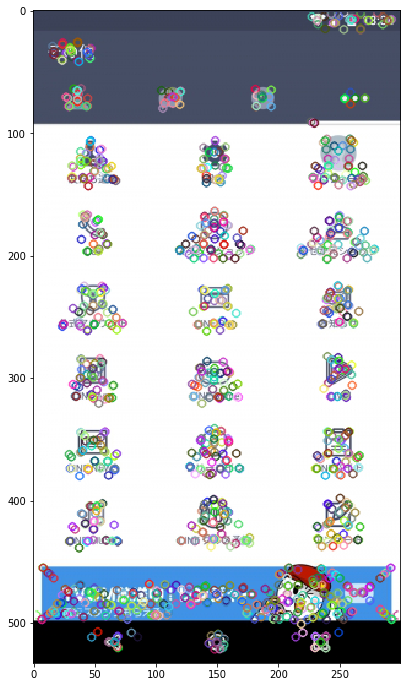

Matches origin key points count. : 31


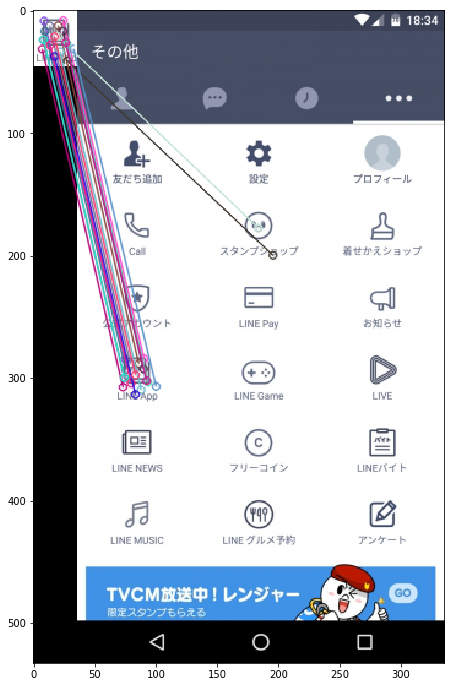

262 : 3515


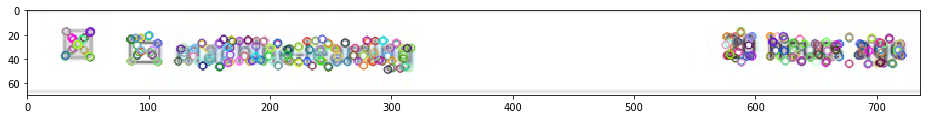

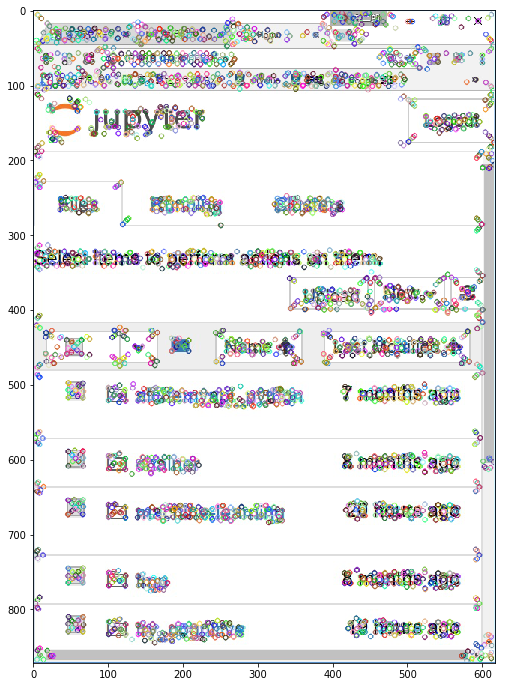

Matches origin key points count. : 262
[[[  16.42874146  638.81469727]]

 [[  16.92470551  702.48779297]]

 [[ 789.36633301  705.03344727]]

 [[ 785.98443604  636.18457031]]]
638.815
705.033
16.4287
705.033


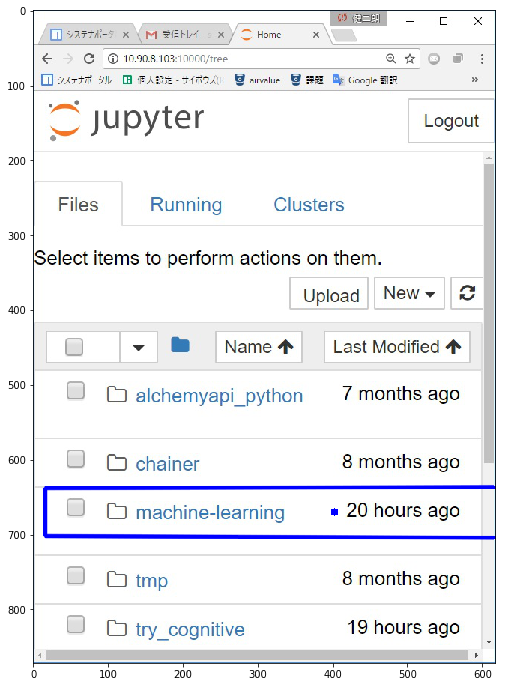

9 : 286


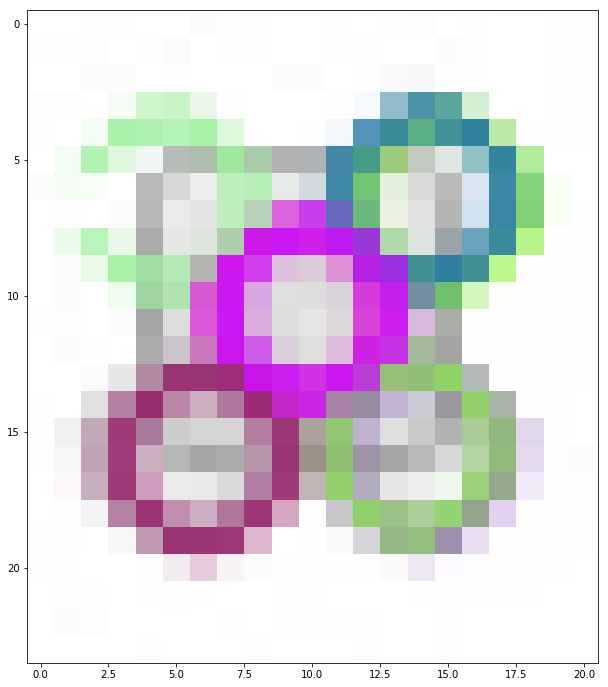

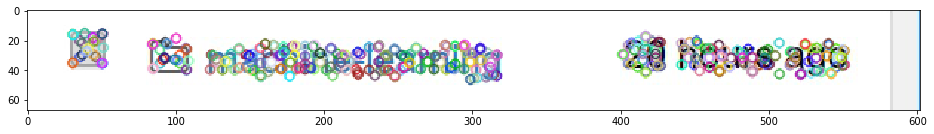

Matches origin key points count. : 9


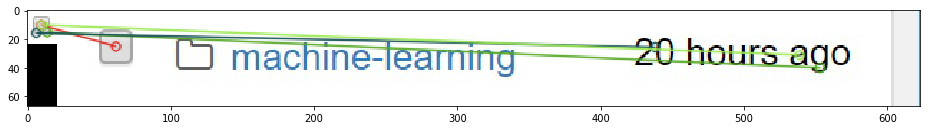

In [26]:
# テストベースシナリオ
SUB_MAP=generate_sub_map()

if __name__ == '__main__':
    cf = CompareFeatures()
    for key in SUB_MAP:
        bs=SUB_MAP[key]
        cf.load_imgs(bs['base'],bs['match'],scale=(1,bs['scale']))
#         cf.show_rect()
#         cf.show_matching()
        if 'is_parent' in bs:
#             bs['val']=cf.get_postion(IS_PARENT=True)
            cf.show_rect(IS_PARENT=True)
#             cf.show_matching()
            continue
#         bs['val']=cf.get_postion()
#         cf.show_rect()
        cf.show_matching()

#     print(SUB_MAP)